In [1]:

import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sarcastic-guru-dataset/Sarcasm_Headlines_Dataset_v2.json


***Importing essential libraries for data processing, NLP, model building, and hyperparameter tuning**.*


In [113]:
!pip install keras-tuner

import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.utils import plot_model

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

***Loading the sarcasm dataset from JSON file into a pandas DataFrame*****.**

In [115]:
data = pd.read_json('/kaggle/input/sarcastic-guru-dataset/Sarcasm_Headlines_Dataset_v2.json', lines=True)
data.head()


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [116]:


data['is_sarcastic'].value_counts()



is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

***Cleaning headlines by removing special characters, lowercasing, tokenizing, removing stopwords, and applying lemmatization**.*

In [117]:
def clean_text(text):
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [WordNetLemmatizer().lemmatize(w) for w in text if w not in stopwords.words('english')]
    return ' '.join(text)

data['clean_headline'] = data['headline'].apply(clean_text)


***Tokenizing cleaned headlines, converting to sequences, padding them to uniform length, and preparing inputs for the model***

In [118]:
sentences = data['clean_headline'].values
labels = data['is_sarcastic'].values

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
max_len = int(np.mean([len(s) for s in sequences]) + 2 * np.std([len(s) for s in sequences]))
padded = pad_sequences(sequences, maxlen=max_len)


***Splitting the data into training, validation, and test sets with stratification to preserve class balance***

In [119]:
X_train, X_test, y_train, y_test = train_test_split(padded, labels, stratify=labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)


***Defining a tunable Bidirectional GRU model with regularization, dropout, and hyperparameter options for robust sarcasm detection***

In [121]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=10000, output_dim=hp.Choice('embed_dim', [32, 64])))
    model.add(tf.keras.layers.GaussianNoise(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
        units=hp.Choice('gru_units', [32, 64]),
        return_sequences=False,
        dropout=hp.Float('gru_dropout', 0.2, 0.4),
        recurrent_dropout=0.2,
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('gru_l2', 1e-4, 1e-2, sampling='log'))
    )))
    model.add(tf.keras.layers.Dense(hp.Choice('dense_units', [16, 32]), activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    model.add(tf.keras.layers.Dropout(hp.Float('dense_dropout', 0.3, 0.5)))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('lr', 1e-4, 1e-3, sampling='log')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


***Performing hyperparameter tuning using Keras Tuner's RandomSearch to find the best model configuration***

In [122]:
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5,
                        executions_per_trial=1, directory='sarcasm_tune', project_name='gru_model')

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
             verbose=2)

best_hp = tuner.get_best_hyperparameters(1)[0]


Trial 5 Complete [00h 02m 40s]
val_accuracy: 0.8109170198440552

Best val_accuracy So Far: 0.8253275156021118
Total elapsed time: 00h 13m 26s


***Retrieving and summarizing the best model and hyperparameters from the tuning process**.*

In [123]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

best_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 11, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 11, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361,793 (1.38 MB)

 Trainable params: 361,793 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

***Training the final model using the best hyperparameters with early stopping to prevent overfitting***.

In [124]:
final_model = build_model(best_hp)
history = final_model.fit(X_train, y_train, epochs=10, batch_size=32,
                          validation_data=(X_val, y_val),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])



Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5266 - loss: 0.7614 - val_accuracy: 0.6406 - val_loss: 0.7050
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.6433 - loss: 0.6692 - val_accuracy: 0.7782 - val_loss: 0.5285
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.7439 - loss: 0.5468 - val_accuracy: 0.7961 - val_loss: 0.4706
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.7796 - loss: 0.4853 - val_accuracy: 0.8153 - val_loss: 0.4311
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8082 - loss: 0.4428 - val_accuracy: 0.8210 - val_loss: 0.4204
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8293 - loss: 0.4033 - val_accuracy: 0.8223 - val_loss: 0.4077
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8398 - loss: 0.3831 - val_accuracy: 0.8227 - val_loss: 0.4073
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8487 - loss: 0.3603 - 

***Plotting training and validation accuracy to visualize model performance over epochs**.*

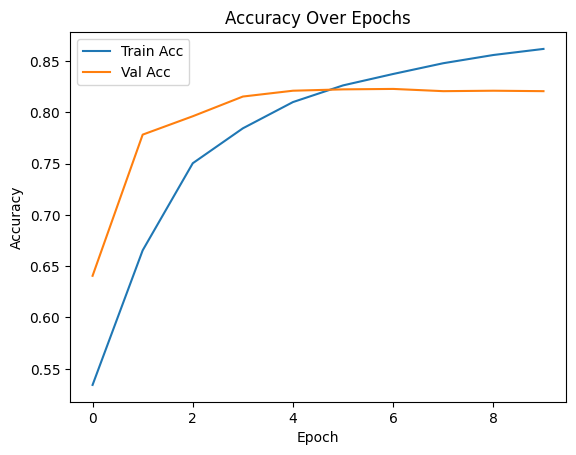

In [125]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


***Plotting training and validation loss to monitor overfitting and learning progression**.*

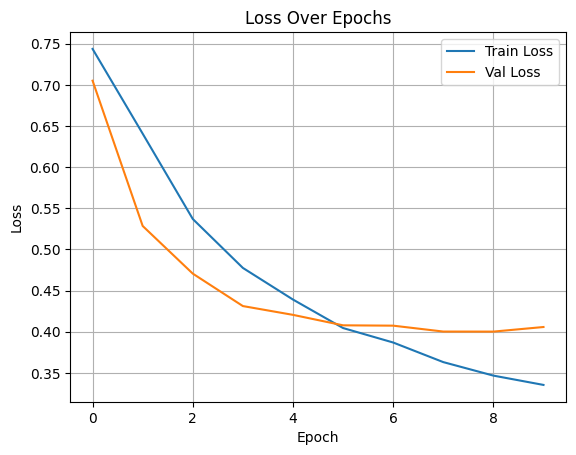

In [126]:


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


***Evaluating the model on the test set using accuracy, precision, recall, F1 score, and confusion matrix***

In [127]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
y_test_array = np.array(y_test)

acc = accuracy_score(y_test_array, y_pred)
prec = precision_score(y_test_array, y_pred)
rec = recall_score(y_test_array, y_pred)
f1 = f1_score(y_test_array, y_pred)
cm = confusion_matrix(y_test_array, y_pred)
report = classification_report(y_test_array, y_pred)

print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(prec))
print("Recall: {:.4f}".format(rec))
print("F1 Score: {:.4f}".format(f1))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.5266
Precision: 0.5042
Recall: 0.3704
F1 Score: 0.4271

Confusion Matrix:
 [[2004  993]
 [1717 1010]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.67      0.60      2997
           1       0.50      0.37      0.43      2727

    accuracy                           0.53      5724
   macro avg       0.52      0.52      0.51      5724
weighted avg       0.52      0.53      0.52      5724



***visualizing the confusion matrix to understand model prediction distribution across classes.***

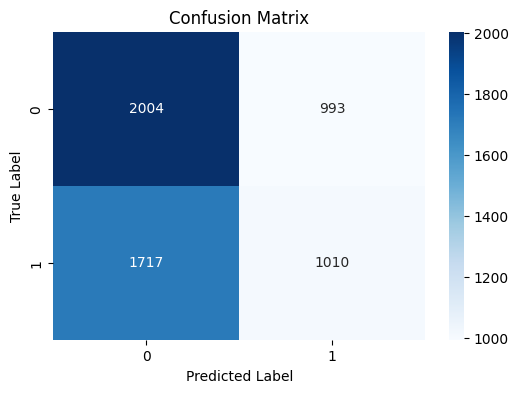

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


***Saving the trained model to an H5 file for future inference or deployment**.*

In [129]:
final_model.save("sarcasm_model.h5")


***Saving the trained model and tokenizer to Kaggle's working directory for download or deployment.***

In [131]:
model.save("/kaggle/working/sarcasm_model.h5")

import pickle
with open("/kaggle/working/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

***Zipping the model and tokenizer files into a single package for easy download**.*

In [132]:
import zipfile

with zipfile.ZipFile("/kaggle/working/sarcasm_model_package.zip", 'w') as zipf:
    zipf.write("/kaggle/working/sarcasm_model.h5")
    zipf.write("/kaggle/working/tokenizer.pkl")